\# Model training has been changed. This script is now only for data generation.

<h3>Introduction</h3>

1. Using existing hand gesture datasets to pre-train model would be beneficial.
2. Ideally, model size would be small.
3. Training and data collection should not be too much of a hassle.

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

import os

<h3>Data Collection</h3>

At the current stage, the dataset will only include 2 gestures. Images will be rectangular (utilizing the full FOV of
the webcam).

In [2]:
# Dictionary mapping key press to label
gestures = {
    ord('a'): 0,  # thumb pointing left
    ord('d'): 1  # thumb pointing right
}

# Initialize empty arrays; data will be read from folder or added in batches
images, labels = [], []

# Load previously saved images
# the folder in which the dataset is stored
base_folder = 'images/left_right_test'

if os.path.exists(base_folder):
    for folder in os.listdir(base_folder):
        label = int(folder)
        folder_path = os.path.join(base_folder, folder)
        
        for img in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, img))      
            images.append(img)
            labels.append(label)

In [3]:
# Empty arrays for the batch
images_batch, labels_batch = [], []

# Initialize window
cv2.namedWindow('collection')
capture = cv2.VideoCapture(0)

if capture.isOpened():
    ret, frame = capture.read()
else:
    raise AssertionError('Video capture is not opened successfully')


# Collect data
while ret:
    cv2.imshow('collection', frame)
    ret, frame = capture.read()

    # Handle key presses
    key = cv2.waitKey(20)

    # ESC
    if key == 27:
        break

    # Remove last (image, label) pair
    if key == 8:
        print('X', end=' ')
        images_batch.pop()
        labels_batch.pop()

    # Gestures
    for k, label in gestures.items():
        if key == k:
            print(label, end=' ')

            # Resize image to (224, 224)
            frame = cv2.resize(frame, (224, 224))

            # Flip horizontally
            frame = frame[:, ::-1, :]

            images_batch.append(frame)
            labels_batch.append(label)

capture.release()
cv2.destroyWindow('collection')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [4]:
# Images array is empty
if len(images) == 0:
    images = np.array(images_batch)
    labels = np.array(labels_batch)
else:
    images = np.append(images, images_batch, axis=0)
    labels = np.append(labels, labels_batch, axis=0)

In [5]:
images = np.array(images)
labels = np.array(labels)

In [6]:
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
unique, counts = np.unique(labels, return_counts=True)
print('Label counts:', dict(zip(unique, counts)))

Images shape: (62, 224, 224, 3)
Labels shape: (62,)
Label counts: {0: 29, 1: 33}


<h3>Visualize a few examples</h3>

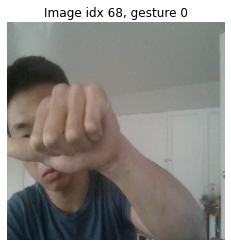

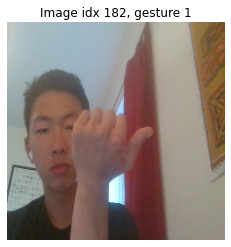

In [37]:
# Used again later after preprocessing
def visualize_examples(imgs, lbs):
    for k, g in gestures.items():
        idx = np.random.choice(np.where(lbs == g)[0])

        plt.title('Image idx {}, gesture {}'.format(idx, g))
        plt.imshow(imgs[idx][:, :, ::-1])
        plt.axis('off')
        plt.show()

visualize_examples(images, labels)

<h3>Save generated data</h3>

In [8]:
dataset_dir = base_folder

for label in gestures.values():
    os.makedirs(os.path.join(dataset_dir, str(label)), exist_ok=True)

for i, (image, label) in enumerate(zip(images, labels)):
    label_folder = os.path.join(dataset_dir, str(label))
    cv2.imwrite(os.path.join(label_folder, f'{i}.jpg'), image)

<h3>Data preprocessing</h3>

1. Normalize images to [0, 1]
2. Shuffle
3. Create train/val/test split

In [39]:
# Make copies of originals
X, y = images.copy(), labels.copy()

# Make y one-hot encoding
y_one_hot = np.zeros((len(y), np.max(y) + 1))
y_one_hot[np.arange(len(y)), y] = 1
y = y_one_hot

# Normalize images
min_, max_ = np.min(X), np.max(X)
X = X / 255.
# X = (X - min_) / (max_ - min_)
print('(New) images value range:', np.min(X), '-', np.max(X))

(New) images value range: 0.0 - 1.0


In [40]:
# Shuffle images
n = len(X)
indices = np.arange(n)
np.random.shuffle(indices)
X, y = X[indices], y[indices]

In [41]:
train, val, test = 0.6, 0.2, 0.2
assert train + val + test == 1

n_train = int(n * train)
n_val = int(n * val)

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]

print('Train samples:', len(X_train))
print('Validation samples:', len(X_val))
print('Test samples:', len(X_test))

Train samples: 165
Validation samples: 55
Test samples: 55


<h3>Load model</h3>
Considering that I am training the model on CPU, I will be using a relatively small (but powerful) model--EfficientNet.

In [42]:
import efficientnet.tfkeras as efn

model = efn.EfficientNetB0(
    # weights='imagenet',
    weights=None,
    classes=len(gestures),
    include_top=True
)
model.count_params()

4052126

In [43]:
import tensorflow as tf

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [44]:
# Oh come on this was such a dumb ass mistake
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.batch(32)

dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
dataset_val = dataset_val.batch(32)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.batch(32)

In [45]:
def evaluate_model(X_, y_):
    # For some reason, without the `training=True` flag, the model does not perform as expected
    y_pred = model(X_, training=True)
    return tf.keras.losses.BinaryCrossentropy()(y_, y_pred), \
        tf.keras.metrics.Accuracy()(np.argmax(y_, axis=1), np.argmax(y_pred, axis=1))

In [48]:
for i in range(3):
    model.fit(dataset, epochs=1)
    print(evaluate_model(X_val, y_val))

9/9 [==============================] - 25s 3s/step - loss: 0.1851 - accuracy: 0.9600
(<tf.Tensor: shape=(), dtype=float32, numpy=0.1829746>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9818182>)
9/9 [==============================] - 25s 3s/step - loss: 0.2513 - accuracy: 0.9236
(<tf.Tensor: shape=(), dtype=float32, numpy=0.15591384>, <tf.Tensor: shape=(), dtype=float32, numpy=0.94545454>)
9/9 [==============================] - 25s 3s/step - loss: 0.1181 - accuracy: 0.9782
(<tf.Tensor: shape=(), dtype=float32, numpy=0.17870253>, <tf.Tensor: shape=(), dtype=float32, numpy=0.96363634>)


In [49]:
evaluate_model(X_test, y_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.17554645>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.96363634>)

0 

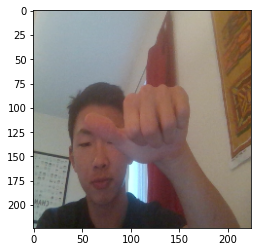

tf.Tensor([[0.9629298  0.03707024]], shape=(1, 2), dtype=float32)
1 

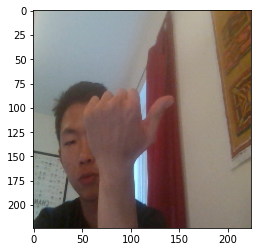

tf.Tensor([[9.9977785e-01 2.2211943e-04]], shape=(1, 2), dtype=float32)


In [53]:
# Initialize window
cv2.namedWindow('test')
capture = cv2.VideoCapture(0)

if capture.isOpened():
    ret, frame = capture.read()
else:
    raise AssertionError('Video capture is not opened successfully')


# Collect data
while ret:
    cv2.imshow('test', frame)
    ret, frame = capture.read()

    # Handle key presses
    key = cv2.waitKey(20)

    # ESC
    if key == 27:
        break

    # Gestures
    for k, label in gestures.items():
        if key == k:
            print(label, end=' ')

            # Resize image to (224, 224)
            frame = cv2.resize(frame, (224, 224))

            # Flip horizontally
            frame = frame[:, ::-1, :]

            # Normalize
            frame = frame / 255.
            prev = frame

            plt.imshow(frame[:, :, ::-1])
            plt.show()
            # Hmm -> this might have been where is issue was
            pred = model(np.array([frame]), training=True)
            print(pred)

capture.release()
cv2.destroyWindow('test')

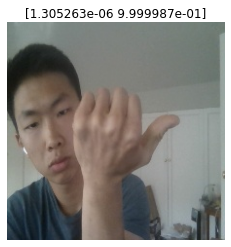

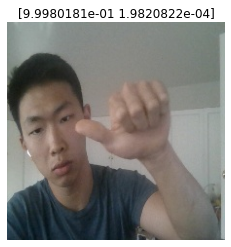

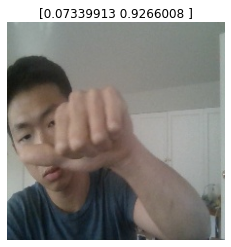

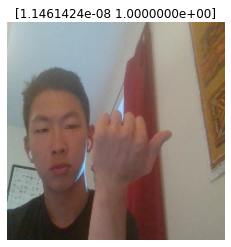

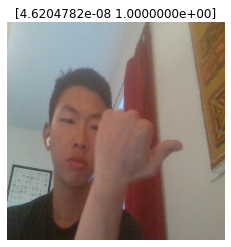

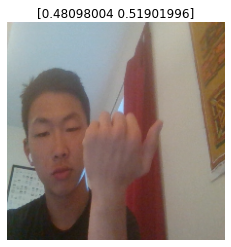

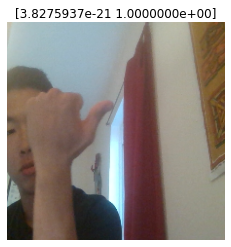

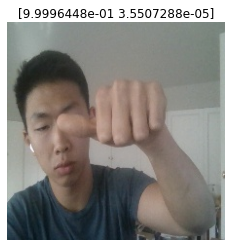

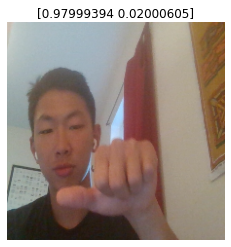

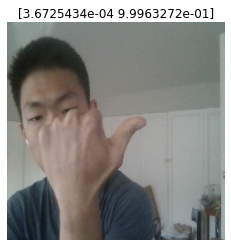

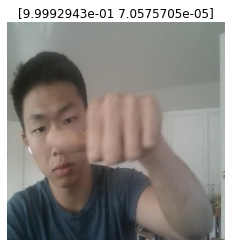

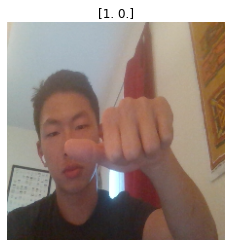

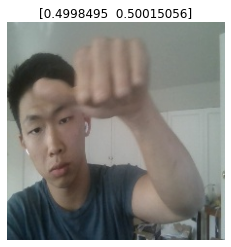

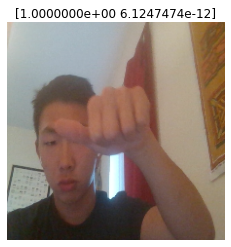

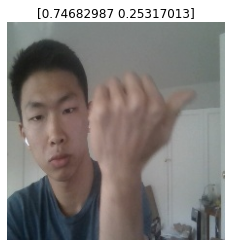

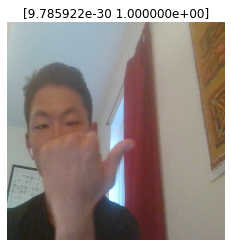

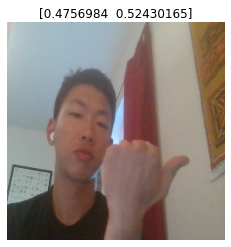

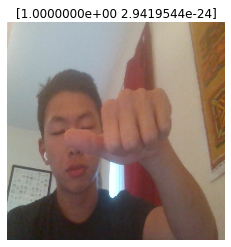

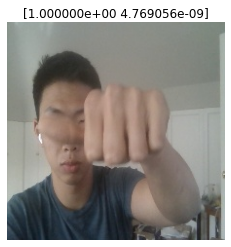

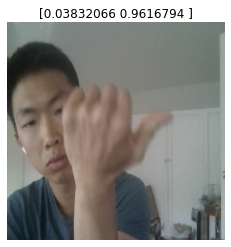

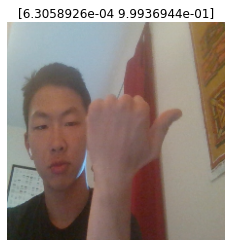

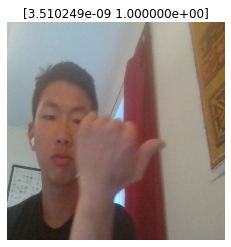

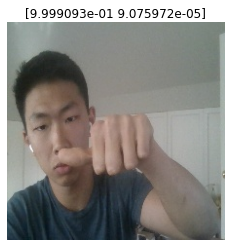

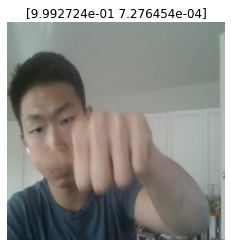

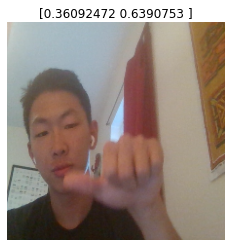

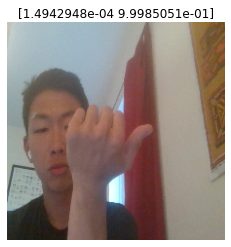

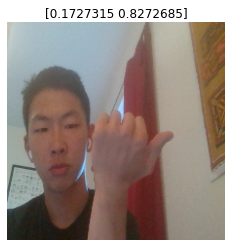

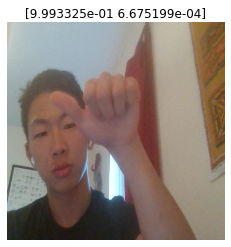

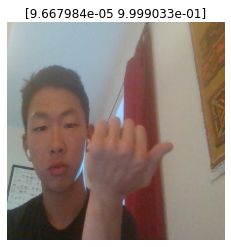

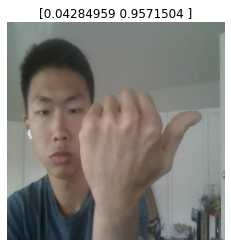

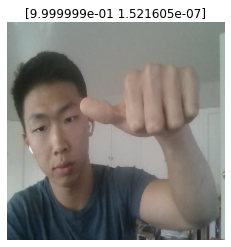

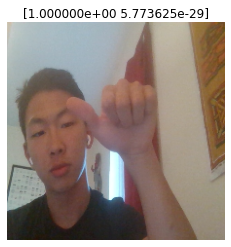

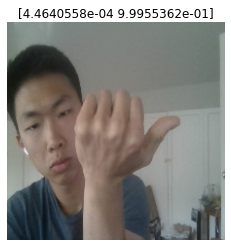

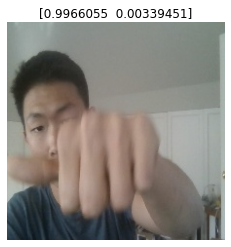

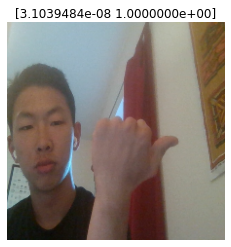

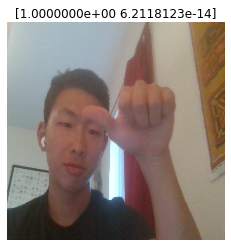

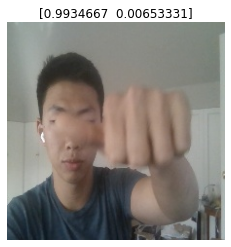

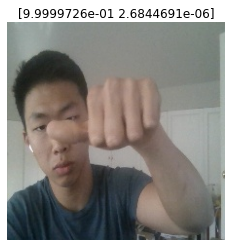

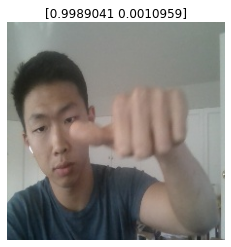

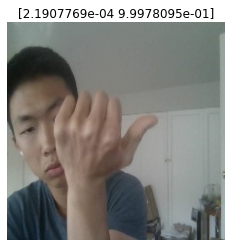

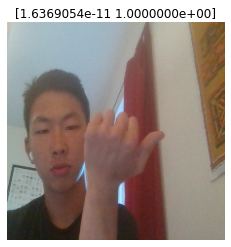

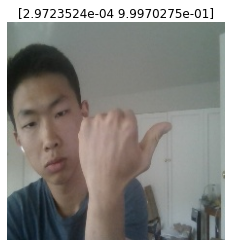

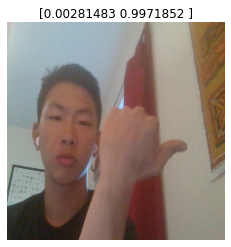

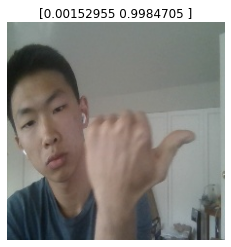

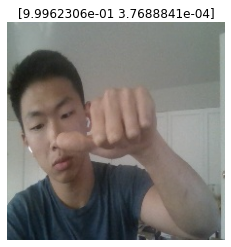

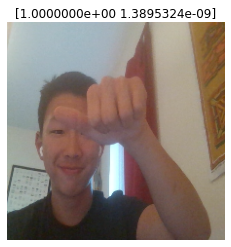

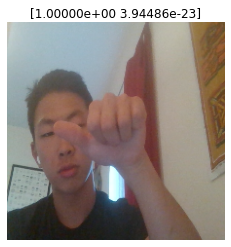

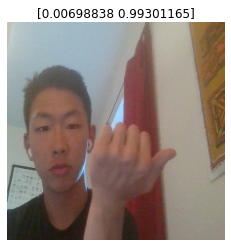

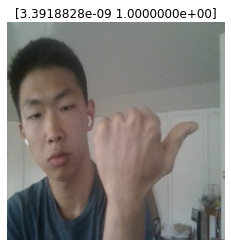

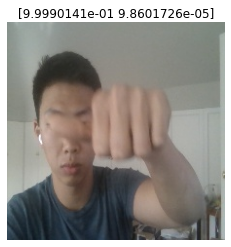

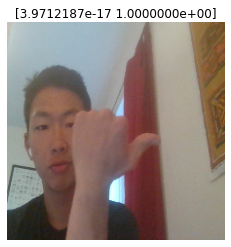

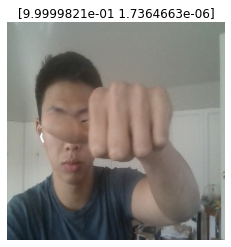

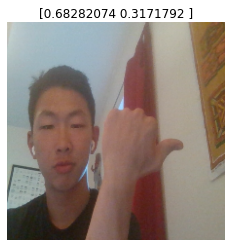

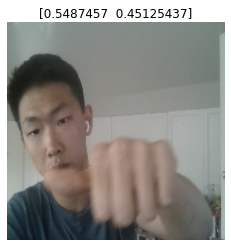

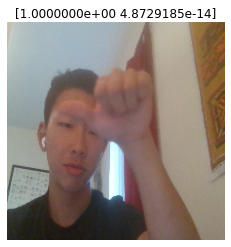

In [51]:
y_pred = model(X_test, training=True)

for i in range(len(X_test)):
    plt.imshow(X_test[i][:, :, ::-1])
    plt.axis('off')
    plt.title(str(y_pred[i].numpy()))
    plt.show()

In [57]:
model(prev.reshape(1, 224, 224, 3), training=True)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.9965579 , 0.00344204]], dtype=float32)>

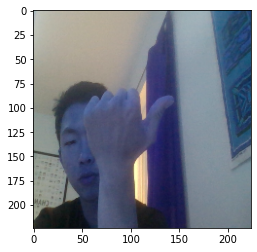

In [58]:
plt.imshow(prev), plt.imshow()